In [1]:
import pandas as pd
import torch
import os
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
sns.set_style('whitegrid')
import pandas as pd
import numpy as np

In [6]:
os.getcwd()

'/home/tduricic/Development/workspace/GraphRec-WWW19-myfork/GraphRec-WWW19/notebooks'

In [3]:
def create_ratings_bipartite_graph(filename):
    users = set()
    items = set()
    user_items_dict = {}
    edges = []
    with open(filename) as fr:
        for line in fr.readlines():
            tokens = line.split()
            userId = tokens[0]
            itemId = tokens[1]
            # For now we omit the weight
            # rating = float(tokens[2])

            users.add(userId)
            items.add(itemId)
            edges.append((userId, itemId))
            if userId not in user_items_dict:
                user_items_dict[userId] = []
                user_items_dict[userId].append(itemId)
            else:
                user_items_dict[userId].append(itemId)
    B = nx.Graph()
    B.add_nodes_from(users, bipartite=0)
    B.add_nodes_from(items, bipartite=1)
    B.add_edges_from(edges)

    return B, user_items_dict, users, items

In [9]:
ratings_filename = '../data/train.tsv'
B, user_items_dict, users, items = create_ratings_bipartite_graph(ratings_filename)

In [12]:
projected_G = bipartite.projected_graph(B, items)
print(len(projected_G.edges))
partition = community_louvain.best_partition(projected_G)
community_lists = {}
for key in partition:
    if partition[key] not in community_lists:
        community_lists[partition[key]] = []
        community_lists[partition[key]].append(key)
    else:
        community_lists[partition[key]].append(key)
print(len(community_lists))

343625
6


In [ ]:
partition

In [13]:
community_sizes = {}
for key in community_lists:
    community_sizes[key] = len(community_lists[key])

In [14]:
community_sizes

{1: 563, 5: 571, 3: 98, 4: 145, 0: 268, 2: 135}

In [16]:
community_sizes_list = list(community_sizes.values())
community_sizes_list.sort(reverse=True)
community_sizes_list

[571, 563, 268, 145, 135, 98]

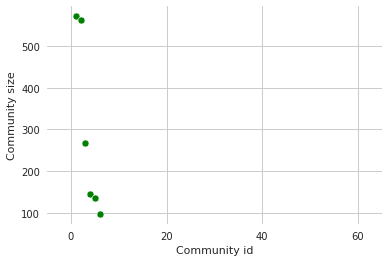

In [17]:
community_ids = range(1, len(community_sizes)+1)
df = pd.DataFrame({"Community id":community_ids, "Community size":community_sizes_list})
sns.set_style('whitegrid')
ax = sns.scatterplot(data=df, x='Community id', y='Community size', color='green')

ax.set(xlim=(-5, 65))
# ax.set(ylim=(-0.1, 3.2))
# ax.set(xticklabels=['',1,'',10,'',100,'',1000,'',10000])
# ax.set(yticklabels=['',1,'',10,'',100,'',1000])
sns.set(font_scale = 1.5)

# plt.savefig('../plots/community_size_distribution1.pdf', bbox_inches='tight')
plt.show()

In [18]:
user_communities_interactions_dict = {}
for userId in user_items_dict:
    if userId not in user_communities_interactions_dict:
        user_communities_interactions_dict[userId] = [0] * len(community_lists)
    for itemId in user_items_dict[userId]:
        user_communities_interactions_dict[userId][partition[itemId]] += 1

In [22]:
np.sum(x/np.max(x))/x.shape[0]

0.28368794326241137

In [23]:
user_diversities = {}
for userId in user_communities_interactions_dict:
    user_community_vector = np.array(user_communities_interactions_dict[userId])
    user_diversities[userId] = np.sum(user_community_vector/np.max(user_community_vector))/user_community_vector.shape[0]

In [24]:
x = np.array(user_diversities.values())

In [25]:
user_diversities_filtered = {}
for userId in user_diversities:
    if user_diversities[userId] > 0 and user_diversities[userId] <=1:
        user_diversities_filtered[userId] = user_diversities[userId]

In [26]:
user_diversities_df = pd.DataFrame({'userId':list(user_diversities_filtered.keys()), 'diversity':list(user_diversities_filtered.values())})

In [27]:
user_diversities_df

,userId,diversity
0,681,0.280702
1,81,0.493827
2,172,0.290476
3,151,0.243333
4,27,0.597222
...,...,...
661,387,0.166667
662,397,0.166667
663,553,0.166667
664,269,0.166667


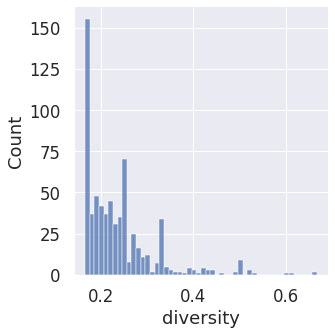

In [28]:
sns.displot(user_diversities_df, x="diversity", bins=50)

In [30]:
source_diversities = []
target_diversities = []
epinions_social_filename = '../data/social_connections.tsv'
with open(epinions_social_filename) as fr:
        for line in fr.readlines():
            tokens = line.split()
            source_user = tokens[0]
            target_user = tokens[1]
            if source_user in user_diversities_filtered and target_user in user_diversities_filtered:
                source_diversities.append(user_diversities_filtered[source_user])
                target_diversities.append(user_diversities_filtered[target_user])

In [31]:
source_diversities = np.array(source_diversities)
target_diversities = np.array(target_diversities)

In [32]:
from scipy.stats.stats import pearsonr
pearsonr(source_diversities, target_diversities)[0]

0.07778531829655605